In [1]:
!pip3 install numpy==1.15.4

     |████████████████████████████████| 13.9MB 254kB/s 
ERROR: umap-learn 0.4.6 has requirement numpy>=1.17, but you'll have numpy 1.15.4 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.15.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: astropy 4.0.1.post1 has requirement numpy>=1.16, but you'll have numpy 1.15.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [1]:
import pandas as pd
import numpy as np
import re
import json
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F

from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm import notebook

import h5py
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/My\ Drive

/content/drive/My Drive


In [5]:
def labels_map(y):
    S=set(y)
    num=len(S)
    dic={word:i for i, word in enumerate(S)}
    
    labels=y.apply(lambda val: dic[val])
    
    return labels.values    

# All names and categories

In [ ]:
df=pd.read_hdf('name_category.h5',key='data',mode='r')

In [ ]:
num_classes=len(set(df['category'].values))
num_classes

1186

In [ ]:
df['category'].value_counts()[:10]

Adviesbureaus - organisatieadvies en management    86212
Bouwbedrijf                                        45854
Diversen                                           29561
Computersoftware                                   24150
Kapper                                             22471
Adviesbureaus                                      19873
Schoonheidsspecialiste                             19279
Adviesbureaus - automatisering                     19058
Administratiekantoor                               16944
Reclame                                            16448
Name: category, dtype: int64

### Small subset

In [ ]:
lst=['Bouwbedrijf','Computersoftware','Kapper','Reclame','Administratiekantoor','Adviesbureaus']
df_reduced=df[df['category'].isin(lst)].copy()
df_reduced.loc[:,'name']=df_reduced['name'].str.lower()

# Experimental categories

In [6]:
df=pd.read_hdf('data_conv_experimental.h5',key='data',mode='r')
df.loc[:,'name']=df['name'].str.lower()
df['category0'].value_counts()

In [7]:
labels=labels_map(df['category0'])
num_classes=len(set(labels))
print("Number of classes: ",num_classes)

Number of classes:  9


### Small subset

In [ ]:
lst=['diensten','winkel','gereedschap']
idx=  df['category0'].isin(lst)
df_reduced=df[idx].copy()

In [ ]:
labels=labels_map(df_reduced['category0'])
num_classes=len(set(labels))

# Pythorch model

In [13]:
max_length=40
alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "
args={'alphabet':alphabet,'number_of_characters':len(alphabet),'max_length':max_length,'dropout_input':0.2,'number_of_classes':num_classes}

In [15]:
args

{'alphabet': 'abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:\'"/\\|_@#$%^&*~`+-=<>()[]{} ',
 'dropout_input': 0.2,
 'max_length': 40,
 'number_of_characters': 70,
 'number_of_classes': 9}

In [72]:
class CharacterLevelCNN(nn.Module):
    def __init__(self, args):
        super(CharacterLevelCNN, self).__init__()

        # define conv layers
        self.drop_input=nn.Dropout2d(0.3)
        self.conv1 = nn.Sequential(nn.Conv1d(args['number_of_characters'],
                                             500,
                                             kernel_size=12,
                                             padding=0),nn.BatchNorm1d(500),
                                   nn.ReLU(),
                                   nn.MaxPool1d(3)
                                   )

        self.conv2 = nn.Sequential(nn.Conv1d(500, 500, kernel_size=5, padding=0),
                                   nn.ReLU(),nn.BatchNorm1d(500),
                                   nn.MaxPool1d(2)
                                   )
      
        self.conv3 = nn.Sequential(nn.Conv1d(100, 100, kernel_size=3, padding=0),
                                   nn.ReLU()
                                   )
        
        
        # compute the  output shape after forwarding an input to the conv layers

        input_shape = (128,
                       args['max_length'],
                       args['number_of_characters'])
        
        self.output_dimension = self._get_conv_output(input_shape)

        # define linear layers

        self.fc1 = nn.Sequential(
            nn.Linear(self.output_dimension, 1000),
            nn.ReLU(),nn.Dropout(0.2)
            
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1000, 1000),
            nn.ReLU()
            
        )

        self.fc3 = nn.Linear(1000, args['number_of_classes'])

        # initialize weights

        self._create_weights()

    # utility private functions

    def _create_weights(self, mean=0.0, std=0.05):
        for module in self.modules():
            if isinstance(module, nn.Conv1d) or isinstance(module, nn.Linear):
                module.weight.data.normal_(mean, std)


    def _get_conv_output(self, shape):
        x = torch.rand(shape)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output_dimension = x.size(1)
        return output_dimension

    # forward

    def forward(self, x):
        x=self.drop_input(x)
        x = x.transpose(1, 2)
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
class CharacterLevelCNN2D(nn.Module):
    def __init__(self, args):
        super(CharacterLevelCNN2D, self).__init__()

        # define conv layers
        self.drop_input=nn.Dropout2d(0.3)
        self.conv1 = nn.Sequential(nn.Conv2d(1,
                                             200,
                                             kernel_size=6,
                                             padding=0),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2)
                                   )

        self.conv2 = nn.Sequential(nn.Conv2d(200, 200, kernel_size=5, padding=0),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2)
                                   )
      
        self.conv3 = nn.Sequential(nn.Conv1d(100, 100, kernel_size=3, padding=0),
                                   nn.ReLU()
                                   )
        
        
        # compute the  output shape after forwarding an input to the conv layers

        input_shape = (128,1,
                       args['max_length'],
                       args['number_of_characters'])
        
        self.output_dimension = self._get_conv_output(input_shape)

        # define linear layers

        self.fc1 = nn.Sequential(
            nn.Linear(self.output_dimension, 600),
            nn.ReLU(),nn.Dropout(0.2)
            
        )

        self.fc2 = nn.Sequential(
            nn.Linear(600, 600),
            nn.ReLU()
            
        )

        self.fc3 = nn.Linear(600, args['number_of_classes'])


    def _get_conv_output(self, shape):
        x = torch.rand(shape)
        x = x.transpose(2, 3)
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.size(0), -1)
        output_dimension = x.size(1)
        return output_dimension

    # forward

    def forward(self, x):
        x=self.drop_input(x)
        x=x.view(x.size(0),1,x.size(1),x.size(2))
        x = x.transpose(2, 3)
        x = self.conv1(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        #x = self.fc2(x)
        x = self.fc3(x)
        return x

In [34]:
args

{'alphabet': 'abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:\'"/\\|_@#$%^&*~`+-=<>()[]{} ',
 'dropout_input': 0.2,
 'max_length': 40,
 'number_of_characters': 70,
 'number_of_classes': 9}

In [30]:
class MyDataset(Dataset):
    def __init__(self, texts, labels, args):
        self.texts = texts
        self.labels = labels
        self.length = len(self.texts)

        self.vocabulary = args['alphabet'] 
        self.number_of_characters = args['number_of_characters'] 
        self.max_length = args['max_length']
        self.identity_mat = np.identity(self.number_of_characters)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        raw_text = self.texts[index]

        data = np.array([self.identity_mat[self.vocabulary.index(i)] for i in list(raw_text) if i in self.vocabulary],
                        dtype=np.float32)
        if len(data) > self.max_length:
            data = data[:self.max_length]
        elif 0 < len(data) < self.max_length:
            data = np.concatenate(
                (data, np.zeros((self.max_length - len(data), self.number_of_characters), dtype=np.float32)))
        elif len(data) == 0:
            data = np.zeros(
                (self.max_length, self.number_of_characters), dtype=np.float32)

        label = self.labels[index]
        data = torch.Tensor(data)

        return data, label

### Focal Loss

In [ ]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): 
            self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): 
            self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, x, target):
        if x.dim()>2:
            x = x.view(x.size(0),x.size(1),-1)  # N,C,H,W => N,C,H*W
            x = x.transpose(1,2)    # N,C,H*W => N,H*W,C
            x = x.contiguous().view(-1,x.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(x)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=x.data.type():
                self.alpha = self.alpha.type_as(x.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: 
            return loss.mean()
        else: 
            return loss.sum()

# Train

In [18]:
def train(model, train_loader, epochs, criterion, optimizer, device):
    L=len(train_loader)
    for epoch in range(1, epochs + 1):
        model.train() # Make sure that the model is in training mode.

        total_loss = 0
        iterator=notebook.tqdm(train_loader)
        for batch in iterator:
            # get data
            batch_x, batch_y = batch
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()

            # get predictions from model
            y_pred = model(batch_x)
        
            # perform backprop
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        iterator.close()
        print("Epoch: {}, Loss: {}".format(epoch, total_loss / L))

# Train/Test data processing

In [40]:
indices=np.arange(df.shape[0])
np.random.shuffle(indices)
idx_small=indices[:2*10**5]
data_x=df.iloc[idx_small].copy()['name'].values
data_y=labels[idx_small]

nb_validation=int(0.2*len(idx_small))

x_train=data_x[:-nb_validation]
y_train=data_y[:-nb_validation]

x_test=data_x[-nb_validation:]
y_test=data_y[-nb_validation:]

train_ds=MyDataset(x_train,y_train,args)
test_ds=MyDataset(x_test,y_test,args)
test_dl=torch.utils.data.DataLoader(test_ds, batch_size=128)
train_dl=torch.utils.data.DataLoader(train_ds, batch_size=128)

In [32]:
len(train_ds)+len(test_ds)

200000

## Initialize model and train

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {}.".format(device))

Using device cuda.


In [73]:
model=CharacterLevelCNN(args).to(device)

In [ ]:
model2d=CharacterLevelCNN2D(args).to(device)

In [81]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
loss_fn = FocalLoss(gamma=2)

In [82]:
train(model, train_dl, 20, loss_fn,optimizer, device)


Epoch: 1, Loss: 1.3448972773551942



Epoch: 2, Loss: 1.3396067774772644



Epoch: 3, Loss: 1.3389889365196228



Epoch: 4, Loss: 1.33652861328125



Epoch: 5, Loss: 1.3358064591407777



Epoch: 6, Loss: 1.3366132676124574



Epoch: 7, Loss: 1.3359912264823914



Epoch: 8, Loss: 1.3348399700164795



Epoch: 9, Loss: 1.3345746532440186



Epoch: 10, Loss: 1.33269073677063



Epoch: 11, Loss: 1.3316115877151489



Epoch: 12, Loss: 1.3294215081214904



Epoch: 13, Loss: 1.3302451745033264



Epoch: 14, Loss: 1.331492476081848



Epoch: 15, Loss: 1.3301577781677245



Epoch: 16, Loss: 1.3286669923782348



Epoch: 17, Loss: 1.328933650779724



Epoch: 18, Loss: 1.3269267228126527



Epoch: 19, Loss: 1.3282467602729797



Epoch: 20, Loss: 1.3270186350822448


In [54]:
 def accuracy(model,val_dl):
  model.eval()
  with torch.no_grad():
        accu=0
        for batch in val_dl:
            val_X,val_y=batch
            val_X=val_X.to(device)
            val_y=val_y.to(device)
            x=model(val_X)
            probs=F.softmax(x,dim=1)
            preds=probs.argmax(dim=1)
            accu+=(preds==val_y).sum().item()
    
  accu=accu/len(val_dl.dataset)*100
  return accu

In [84]:
accuracy(model,train_dl)

54.931875

In [83]:
accuracy(model,test_dl)

43.3275

In [ ]:
df['category'].drop_duplicates().values

array(['Fotowinkel', 'Fotolaboratoria', 'Supermarkt', ..., 'Vitrines',
       'Weerdiensten', 'Wormenkwekerijen'], dtype=object)

In [ ]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [ ]:
get_n_params(model)

3304006

In [ ]:
outputs=[]
model.eval()
with torch.no_grad():
      for batch in test_dl:
          val_X,val_y=batch
          val_X=val_X.to(device)
          val_y=val_y.to(device)
          x=model(val_X)
          probs=F.softmax(x,dim=1)
          preds=probs.argmax(dim=1)
          outputs.append(preds)

In [ ]:
preds=torch.cat(outputs)
names=df_reduced.iloc[indices]
names_val=names.iloc[-nb_validation:]
names_val.loc[:,'labels']=y_test
names_val.loc[:,'preds']=preds.cpu().numpy()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
names_val

,name,category,labels,preds
1866586,habibi,Kapper,1,0
729435,bj afbouwbedijf,Bouwbedrijf,4,4
2483749,yavanna,Reclame,3,4
526391,kapsalon good looking,Kapper,1,1
764250,straalen afbouw g van,Bouwbedrijf,4,4
...,...,...,...,...
213537,fm at work,Adviesbureaus,5,0
987915,harewise,Computersoftware,0,5
669089,yord beauty & hairstyling,Kapper,1,1
210382,campagne consulting,Adviesbureaus,5,0


In [ ]:
dic=names_val[['category','labels']].drop_duplicates().sort_values(by=['labels'])

In [ ]:
label2cat={}
for row in dic.iterrows():
  label2cat[row[1][1]]=row[1][0]

In [ ]:
label2cat

{0: 'Computersoftware',
 1: 'Kapper',
 2: 'Administratiekantoor',
 3: 'Reclame',
 4: 'Bouwbedrijf',
 5: 'Adviesbureaus'}

In [ ]:
error=names_val[names_val['labels']!=names_val['preds']]

In [ ]:
error['preds_name']=error['preds'].apply(lambda x: label2cat[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
for idx, n in error['preds_name'].value_counts().items():
  print(idx,n/names_val['category'].value_counts()[idx]*100)

Computersoftware 47.699608004951514
Bouwbedrijf 24.604818489043932
Adviesbureaus 49.27393551562885
Reclame 55.38273863982922
Administratiekantoor 21.80094786729858
Kapper 16.213151927437643


In [ ]:
names_val['category'].value_counts()['Kapper']

4410

In [ ]:
error[error['preds_name']=='Reclame'].iloc[:20]

,name,category,labels,preds,preds_name
1000812,studio kaan,Computersoftware,0,3,Reclame
741469,hgc+,Bouwbedrijf,4,3,Reclame
56110,maatschap brinksma,Administratiekantoor,2,3,Reclame
741969,hpmi cothen,Bouwbedrijf,4,3,Reclame
983807,denise design,Computersoftware,0,3,Reclame
212111,donci,Adviesbureaus,5,3,Reclame
1002960,van langen ontwerp & advies,Computersoftware,0,3,Reclame
9553,burg en beelen bv,Administratiekantoor,2,3,Reclame
734550,danny van schoten diensten,Bouwbedrijf,4,3,Reclame
10293,bert govers advies,Administratiekantoor,2,3,Reclame


In [ ]:
lens=[len(x) for x in df_reduced['name']]

In [ ]:
lens=np.array(lens)

In [ ]:
import matplotlib.pyplot as plt

(array([2.8691e+04, 6.6946e+04, 3.4744e+04, 1.1909e+04, 2.9170e+03,
        4.9200e+02, 2.9000e+01, 5.0000e+00, 3.0000e+00, 4.0000e+00]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <a list of 10 Patch objects>)

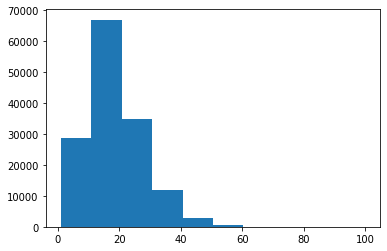

In [ ]:
plt.hist(lens)

In [ ]:
lens.std()

9.097803307701616

In [ ]:
lens.mean()

18.39549883353918